## Import relevant Python packages

In [46]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import ascii

## Define a function that returns a flux (in units of maggies) given an AB magnitude

In [47]:
def flux(mag):
    flux = 10.**(mag/(-2.5))
    return flux

## Define a function that returns inverse variance (in units of magnitudes) given a magnitude and an uncertainty on that magnitude

In [48]:
def ivar(mag, unc):
    flux = 10.**(mag/(-2.5))
    func = flux / 1.086 * unc
    ivar = 1 / func**2
    return ivar

## read in data from a table

In [49]:
table = ascii.read('umeh_table.dat')
print(table)

Galaxy fuv_mag fuv_unc nuv_mag nuv_unc ... w3_unc w4_mag w4_unc   z    ebv 
------ ------- ------- ------- ------- ... ------ ------ ------ ----- -----
 J0826   22.43   0.157  20.393   0.039 ...  0.156  8.534  0.271 0.603 0.037
 J0901  22.036   0.119  20.112   0.039 ...  0.205  8.716  0.352 0.459 0.057
 J0905  23.657    0.43  20.918   0.059 ...  0.166  8.854  0.305 0.712 0.031
 J0944  22.572   0.312  21.238   0.102 ...  0.142  8.488  0.286 0.514 0.026
 J1107  22.919   0.354  21.398   0.104 ...  0.081  8.254  0.205 0.467 0.076
 J1219  22.692    0.48  21.441   0.212 ...  0.081  7.809  0.136 0.451 0.021
 J1341  21.999    0.41  20.139   0.097 ...  0.086  8.153  0.149 0.658 0.037
 J1506  21.394   0.252  19.661   0.074 ...  0.058   7.68  0.076 0.608 0.016
 J1558  21.287   0.317  20.007    0.11 ...  0.039   8.61  0.152 0.402 0.014
 J1613  23.449   0.374  21.129   0.042 ...  0.034  7.299  0.072 0.449 0.041
 J2116   24.28   1.086  21.837   0.117 ...  0.266  9.594  1.086 0.728 0.147
 J2140  24.1

## Specify the galaxy you want

In [50]:
galaxy = 'J0901'

## find this galaxy in the table

In [51]:
match = table.field('Galaxy') == galaxy
print(match)

[False  True False False False False False False False False False False]


## Create a Python dictionary that includes the flux, inverse variance, and central wavelength for the following filter bandpasses: 

### ultraviolet: FUV and NUV from GALEX (Galaxy Evolution Explorer)
### optical: ugriz from SDSS (Sloan Digital Sky Survey)
### infrared: w1/w2/w2/w4 from WISE (Wide-field Infrared Survey Explorer)

#### Note: the WISE magnitudes in the table are Vega magnitudes, and we are including a correction to ensure that the flux and inverse variance values are correct

In [52]:
# create a photometry dictionary
phot = dict(
    FUV=(flux(table.field('fuv_mag')[match][0]), ivar(table.field('fuv_mag')[match][0], table.field('fuv_unc')[match][0]), 0.1528),
    NUV=(flux(table.field('nuv_mag')[match][0]), ivar(table.field('nuv_mag')[match][0], table.field('nuv_unc')[match][0]), 0.2271),
    u=(flux(table.field('u_mag')[match][0]), ivar(table.field('u_mag')[match][0], table.field('u_unc')[match][0]), 0.3543),
    g=(flux(table.field('g_mag')[match][0]), ivar(table.field('g_mag')[match][0], table.field('u_unc')[match][0]), 0.4770),
    r=(flux(table.field('r_mag')[match][0]), ivar(table.field('r_mag')[match][0], table.field('u_unc')[match][0]), 0.6231),
    i=(flux(table.field('i_mag')[match][0]), ivar(table.field('i_mag')[match][0], table.field('u_unc')[match][0]), 0.7625),
    z=(flux(table.field('z_mag')[match][0]), ivar(table.field('z_mag')[match][0], table.field('u_unc')[match][0]), 0.9134),
    w1=(flux(table.field('w1_mag')[match][0])*306.681/3631, ivar(table.field('w1_mag')[match][0], table.field('w1_unc')[match][0])*(3631/306.681)**2, 3.368),
    w2=(flux(table.field('w2_mag')[match][0])*170.663/3631, ivar(table.field('w2_mag')[match][0], table.field('w2_unc')[match][0])*(170.663/3631)**-2, 4.618),
    w3=(flux(table.field('w3_mag')[match][0])*29.0448/3631, ivar(table.field('w3_mag')[match][0], table.field('w3_unc')[match][0])*(29.0448/3631)**-2, 12.082),
    w4=(flux(table.field('w4_mag')[match][0])*8.2839/3631, ivar(table.field('w4_mag')[match][0], table.field('w4_unc')[match][0])*(8.2839/3631)**-2, 22.194))

## use the information above to define wavelength, flux, and uncertainty arrays

In [53]:
wave = np.array([phot[filt][2] for filt in phot.keys()])
f_gal = np.array([phot[filt][0] for filt in phot.keys()])
uncert = np.sqrt((np.array([phot[filt][1] for filt in phot.keys()]))**(-1))

In [56]:
template = ascii.read('Composite1.txt')

## Let's make a figure using matplotlib

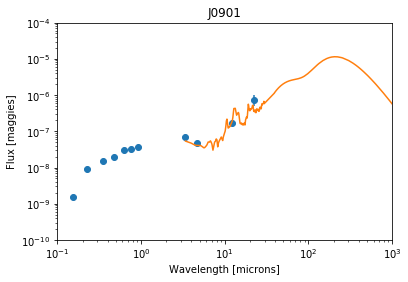

In [62]:
# plot wavelength on the x axis and flux on the y axis
plt.scatter(wave, f_gal)

# set parameters of the y axis
plt.yscale('log')
plt.ylim([1e-10,1e-4])
plt.ylabel('Flux [maggies]')

# set parameters of the x axis
plt.xscale('log')
plt.xlim([0.1, 1000.])
plt.xlabel('Wavelength [microns]')
plt.title(galaxy)

#Adds vertical errorbars
plt.errorbar(wave, f_gal, yerr=uncert, xerr=None, ls='none')

factor = 3e30
plt.plot(template['wavelength']*(1+0.7), template['luminosity']/factor)

plt.show()

## Check the percent uncertainties for each flux value

### The uncerainties are usualy <5% for the optical bands (and sometimes also for NUV and W1)
### The uncertainties can be >10% for the ultraviolet bands (especially FUV) and the infrared bands (especially W3 and W4)

In [45]:
print(uncert / f_gal)

[0.10957643 0.0359116  0.0267035  0.0267035  0.0267035  0.0267035
 0.0267035  0.02025783 0.05893186 0.18876611 0.32412523]
